In [38]:
from metrics_toolbox import MetricEnum, ReducerEnum, EvaluatorBuilder
from metrics_toolbox.evaluator import MetricEvaluator
from metrics_toolbox.encoding import toolbox_binarize_labels
import numpy as np
import matplotlib.pyplot as plt

## Mock data for anomaly detection

In [39]:
# Parameters
n_samples_train = 1000
n_samples_test = 300
anomaly_start = 150
anomaly_end = 300

# Time axis
t_train = np.linspace(0, 10, n_samples_train)
t_test = np.linspace(10, 13, n_samples_test)

# Training data - 3 signals with different amplitudes, frequencies, and noise levels
# Signal 1: High amplitude, fast frequency, low noise
train_signal_1 = 2.5 * np.sin(2 * np.pi * 1.0 * t_train)
train_noise_1 = np.random.normal(0, 0.05, n_samples_train)

# Signal 2: Medium amplitude, medium frequency, medium noise
train_signal_2 = 1.2 * np.sin(2 * np.pi * 0.7 * t_train)
train_noise_2 = np.random.normal(0, 0.15, n_samples_train)

# Signal 3: Low amplitude, slow frequency, high noise
train_signal_3 = 0.6 * np.sin(2 * np.pi * 0.3 * t_train)
train_noise_3 = np.random.normal(0, 0.5, n_samples_train)

X_train = np.column_stack([
    train_signal_1 + train_noise_1,
    train_signal_2 + train_noise_2,
    train_signal_3 + train_noise_3
])

# Test data - same structure with corresponding variations
test_signal_1 = 2.5 * np.sin(2 * np.pi * 1.0 * t_test)
test_noise_1 = np.random.normal(0, 0.05, n_samples_test)

test_signal_2 = 1.2 * np.sin(2 * np.pi * 0.7 * t_test)
test_noise_2 = np.random.normal(0, 0.2, n_samples_test)

test_signal_3 = 0.6 * np.sin(2 * np.pi * 0.3 * t_test)
test_noise_3 = np.random.normal(0, 0.5, n_samples_test)

X_test = np.column_stack([
    test_signal_1 + test_noise_1,
    test_signal_2 + test_noise_2,
    test_signal_3 + test_noise_3
])

# Binary labels indicating anomaly regions (0=normal, 1=anomaly)
anomaly_labels = np.zeros(n_samples_test, dtype=int)
anomaly_labels[anomaly_start:anomaly_end] = 1

# Add anomalies with different magnitudes per signal
np.random.seed(42)
X_test[anomaly_start:anomaly_end, 0] += np.random.uniform(-0.5, 0.5, anomaly_end - anomaly_start)
X_test[anomaly_start:anomaly_end, 1] += np.random.uniform(-0.3, 0.3, anomaly_end - anomaly_start)
X_test[anomaly_start:anomaly_end, 2] += np.random.uniform(-0.2, 0.2, anomaly_end - anomaly_start)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Anomaly labels shape: {anomaly_labels.shape}")
print(f"Number of anomalies: {anomaly_labels.sum()}")
print(f"\nSignal characteristics:")
print(f"Signal 1: amplitude=2.5, noise_std=0.05, range=[{X_train[:, 0].min():.2f}, {X_train[:, 0].max():.2f}]")
print(f"Signal 2: amplitude=1.2, noise_std=0.15, range=[{X_train[:, 1].min():.2f}, {X_train[:, 1].max():.2f}]")
print(f"Signal 3: amplitude=0.6, noise_std=0.25, range=[{X_train[:, 2].min():.2f}, {X_train[:, 2].max():.2f}]")

Training data shape: (1000, 3)
Test data shape: (300, 3)
Anomaly labels shape: (300,)
Number of anomalies: 150

Signal characteristics:
Signal 1: amplitude=2.5, noise_std=0.05, range=[-2.59, 2.61]
Signal 2: amplitude=1.2, noise_std=0.15, range=[-1.64, 1.67]
Signal 3: amplitude=0.6, noise_std=0.25, range=[-2.07, 1.82]


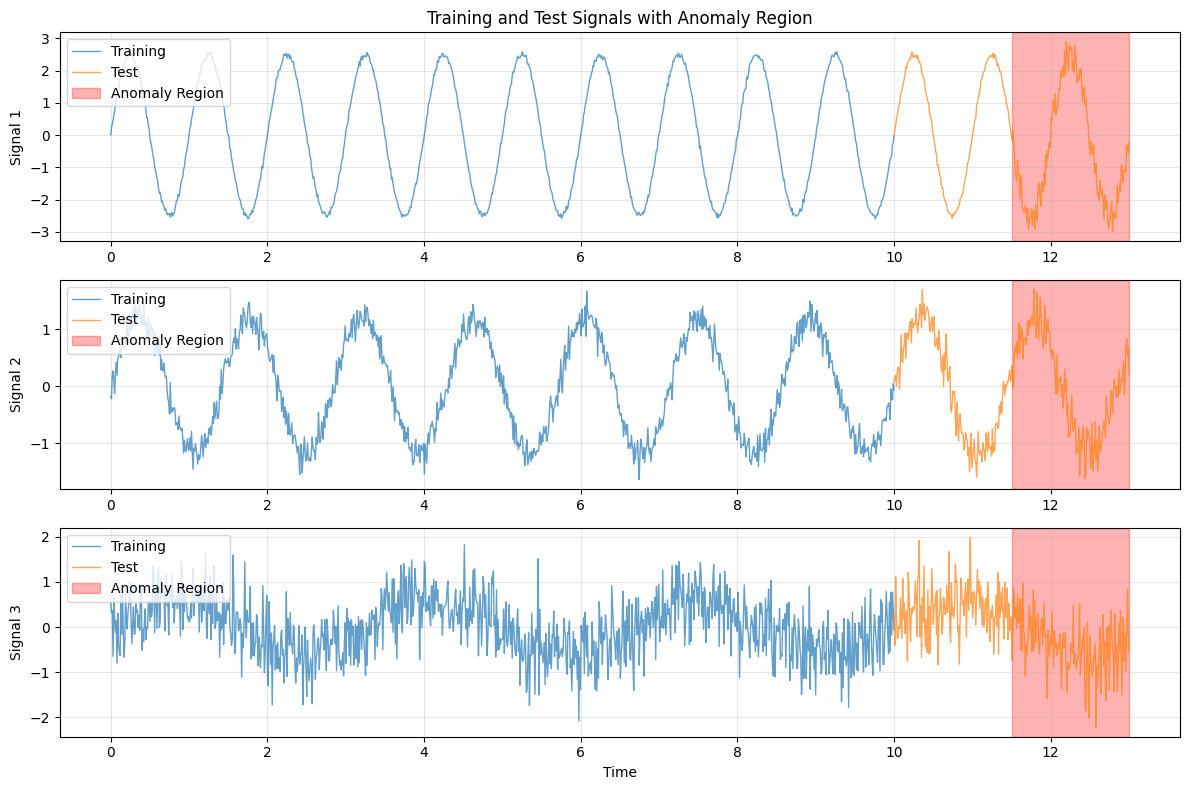

In [40]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Plot each signal
for i in range(3):
    # Training data
    axes[i].plot(t_train, X_train[:, i], label='Training', alpha=0.7, linewidth=1)
    
    # Test data - normal region
    axes[i].plot(t_test, X_test[:, i], label='Test', alpha=0.7, linewidth=1)
    
    # Highlight anomaly region in test data
    axes[i].axvspan(t_test[anomaly_start], t_test[anomaly_end-1], 
                    alpha=0.3, color='red', label='Anomaly Region')
    
    axes[i].set_ylabel(f'Signal {i+1}')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='upper left')

axes[0].set_title('Training and Test Signals with Anomaly Region')
axes[2].set_xlabel('Time')

plt.tight_layout()
plt.show()

## Creat a custom anomaly detection model

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


class PCAReconstructionModel:
    def __init__(self, n_components=1, threshold_percentile=95):
        """
        PCA-based anomaly detection using reconstruction error.
        
        Parameters
        ----------
        n_components : int
            Number of PCA components to keep
        threshold_percentile : float
            Percentile of reconstruction errors to use as threshold (0-100)
        """
        self.n_components = n_components
        self.threshold_percentile = threshold_percentile
        self.scaler = MinMaxScaler()
        self.pca = PCA(n_components=n_components)
        self.mean_ = None
        self.thresholds = None
        
    def fit(self, X):
        """
        Fit the model to training data.
        
        Parameters
        ----------
        X : np.ndarray
            Training data of shape (n_samples, n_features)
        """
        # Step 1: MinMax scale to [0, 1]
        X_scaled = self.scaler.fit_transform(X)
        
        # Step 2: Center by subtracting mean
        self.mean_ = X_scaled.mean(axis=0)
        X_centered = X_scaled - self.mean_
        
        # Step 3: Fit PCA on centered data
        self.pca.fit(X_centered)
        
        # Calculate reconstruction errors on training data to set thresholds
        X_reconstructed_scaled = self._reconstruct_scaled(X_scaled)
        reconstruction_errors = np.square(X_scaled - X_reconstructed_scaled)
        
        # Set threshold for each feature/signal
        self.thresholds = np.percentile(reconstruction_errors, 
                                       self.threshold_percentile, 
                                       axis=0)
        
        return self
    
    def _reconstruct_scaled(self, X_scaled):
        """Internal method to reconstruct in scaled space [0,1]."""
        # Center
        X_centered = X_scaled - self.mean_
        # PCA transform and inverse
        X_pca = self.pca.transform(X_centered)
        X_reconstructed_centered = self.pca.inverse_transform(X_pca)
        # Add back mean
        X_reconstructed_scaled = X_reconstructed_centered + self.mean_
        return X_reconstructed_scaled
    
    def predict(self, X):
        """
        Predict if samples are anomalies based on reconstruction error.
        
        Parameters
        ----------
        X : np.ndarray
            Test data of shape (n_samples, n_features)
            
        Returns
        -------
        np.ndarray
            Binary array (n_samples,) where 1 indicates anomaly
        """
        X_scaled = self.scaler.transform(X)
        X_reconstructed_scaled = self._reconstruct_scaled(X_scaled)
        
        # Calculate reconstruction errors in scaled space
        reconstruction_errors = np.square(X_scaled - X_reconstructed_scaled)
        
        # Check if any feature exceeds its threshold
        anomalies = np.any(reconstruction_errors > self.thresholds, axis=1).astype(int)
        
        return anomalies
    
    def predict_values(self, X):
        """
        Return reconstructed signal values.
        
        Parameters
        ----------
        X : np.ndarray
            Test data of shape (n_samples, n_features)
            
        Returns
        -------
        np.ndarray
            Reconstructed signals in original scale (n_samples, n_features)
        """
        X_scaled = self.scaler.transform(X)
        X_reconstructed_scaled = self._reconstruct_scaled(X_scaled)
        
        # Inverse transform to original scale
        X_reconstructed = self.scaler.inverse_transform(X_reconstructed_scaled)
        
        return X_reconstructed

## Fit the model to mock data

In [42]:
# Train the PCA reconstruction model
model = PCAReconstructionModel(n_components=2, threshold_percentile=95)
model = model.fit(X_train)

## Create a custom Evaluator
### You can automatically combine Classification and Regression metrics for any custom model

In [43]:
class MyEvaluator(MetricEvaluator):

    # Padd all initialization to constructor
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        

    def evaluate_model(self, model, X, y_true, column_names=None):
        
        # Compute label predictions
        y_pred = model.predict(X)
        y_pred = toolbox_binarize_labels(y_pred, classes=[0, 1])
        y_true = toolbox_binarize_labels(y_true, classes=[0, 1])        
        self.add_label_evaluation(
            y_true=y_true,
            y_pred=y_pred,
            column_names=[0, 1],  
        )

        # Compute regression predictions
        X_pred = model.predict_values(X)
        self.add_regression_evaluation(
            y_true=X,
            y_pred=X_pred,
            column_names=column_names,  
        )

In [44]:
evaluator = (
    EvaluatorBuilder()
    .add_metric("mse_target", target_name="signal1")    # Add regression metric for each signal
    .add_metric("mse_target", target_name="signal2")
    .add_metric("mse_target", target_name="signal3")
    .add_metric("mse_macro")
    .add_metric("accuracy")                             # Add classification metric
    .add_metric("precision_target", target_name=1) 
).build(MyEvaluator)

display(evaluator)

MetricEvaluator(
metric_specs=[
  MetricSpec(cls=Metric(name=mse, scope=target, type=scores), reducers=(latest)),
  MetricSpec(cls=Metric(name=mse, scope=target, type=scores), reducers=(latest)),
  MetricSpec(cls=Metric(name=mse, scope=target, type=scores), reducers=(latest)),
  MetricSpec(cls=Metric(name=mse, scope=macro, type=scores), reducers=(latest)),
  MetricSpec(cls=Metric(name=accuracy, scope=micro, type=labels), reducers=(latest)),
  MetricSpec(cls=Metric(name=precision, scope=target, type=labels), reducers=(latest)),
])

## Evaluate the anomaly detection model

In [45]:
evaluator.evaluate_model(model, X_test, anomaly_labels, column_names=["signal1", "signal2", "signal3"])

In [46]:
results = evaluator.get_results()
display(results)

{'values': {'mse_signal1_latest': np.float64(0.0014481393917322334),
  'mse_signal2_latest': np.float64(0.00013847888967753207),
  'mse_signal3_latest': np.float64(0.4978498361334971),
  'mse_macro_latest': np.float64(0.16647881813830231),
  'accuracy_latest': 0.5233333333333333,
  'precision_1_latest': np.float64(0.64)},
 'steps': {'mse_signal1_steps': [np.float64(0.0014481393917322334)],
  'mse_signal2_steps': [np.float64(0.00013847888967753207)],
  'mse_signal3_steps': [np.float64(0.4978498361334971)],
  'mse_macro_steps': [np.float64(0.16647881813830231)],
  'accuracy_steps': [0.5233333333333333],
  'precision_1_steps': [np.float64(0.64)]},
 'figures': {'confusion_matrices': <Figure size 600x480 with 2 Axes>,
  'regression_plots': <Figure size 1800x1200 with 6 Axes>}}

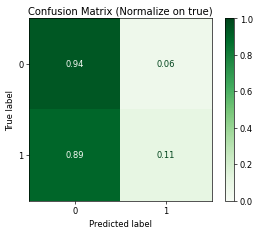

In [47]:
fig = results["figures"]["confusion_matrices"]
fig.set_dpi(60)
fig

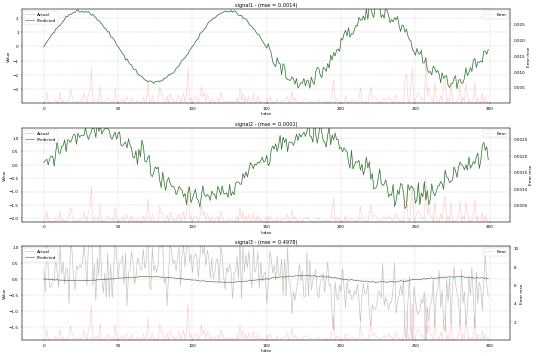

In [50]:
fig = results["figures"]["regression_plots"]
fig.set_dpi(30)
fig